# PHYS 381 - Assignment #6 
#### March 27, 2018
John Ming Ngo (30020834)

Kenneth Barry Sharman (00300185)

# Introduction

This week we were introduced to the concept of an iterated function. Suppose we start with an initial state vector $x_0$ and apply a function to get $x_1$. Repeating this process for $N$ iterations we have:
$$ x_N = f(x_{N-1}) = f( f( \ldots f(x_0) \ldots) ) = f^n(x_0)$$

We will focus on the set of functions that can be written in the form

$$ z_{i+1} = a \, z_i^b + c $$
  
where the state vector is a single real ($x$) or complex ($z$) number.

The Mandelbrot Set is defined as all c values in the complex plane which are bounded when iterated from $z_0=0$:
$$ z_{i+1} = z_i^2 + c $$

In this assignment we will analyze fractals generated from the Mandelbrot set. A fractal is simply a pattern that produces a geometric figure.

We have previously seen that coding with recursion can be relatively expensive. As such, we will make an effort to utilize matrix operations. We will be using a large grid of points, and having the computer perform the same operation to every element in the grid is much more efficient than running the elements through various control structures.  

In [1]:
# Import Standard Packages
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

## Question 1
The 'mandlebrot_set_count' and 'show_mandlebrot_set' functions from the class notes are utlized and defined below. Two versions of the set_count functions are defined. One uses only non-divergent values of z, and the other uses all values of z. We had some trouble determining the periodic points when using the non-divergent function, and as such both were necessary for our analysis.

In [2]:
def mandlebrot_set_count(cgrid, maxloops = 100):
    """ A variant of the function provided in class which doesn't continue to calculate on divergent points. """
    nx, ny = cgrid.shape
    z = np.zeros( [nx,ny], dtype=np.complex )
    nloops = np.zeros( [nx,ny], dtype=np.int16 )
    
    for i in range(maxloops):
        working = np.abs(z) < 2.0
        notWorking = np.abs(z) >= 2.0
        z[working] = z[working]**2 + cgrid[working]
        nloops[working] = i
        
    return nloops, nloops[working], nloops[notWorking]

def mandlebrot_set_count1(cgrid, maxloops = 999):
    """ The original function. Author: Professor Brian Jackel """
    nx, ny = cgrid.shape
    z = np.zeros( [nx,ny], dtype=np.complex )
    nloops = np.zeros( [nx,ny], dtype=np.int16 )
    
    for i in range(maxloops):
        z = z**2 + cgrid
        nloops[ np.abs(z) < 2] = i
        
    return nloops

def show_mandlebrot_set(nx=299, ny=301, xlim=[-0.75,-0.4], ylim=[0.45,0.8], maxloops=999, plot=False, allZ = False):
    """ The function as provided in the notes. Author: Professor Brian Jackel """
    x = np.linspace( xlim[0], xlim[1], nx )
    y = np.linspace( ylim[0], ylim[1], ny )
    xx, yy = np.meshgrid( x, y )
    c = xx + yy*1j
    
    if allZ == False:
        countgrid = mandlebrot_set_count(c, maxloops)
    else:
        countgrid = mandlebrot_set_count1(c, maxloops)
        
    if plot:
        corners = ( np.min(xx), np.max(xx), np.min(yy), np.max(yy) )
        plt.figure( figsize=(6,6) )
        plt.imshow( countgrid, extent=corners)
        plt.set_cmap('prism')  
    else:
        return countgrid

As a preliminary exercise, we will determine the percentage of points that do not diverge through the course of the first 100 iterations. This can be done using the functions defined above, along with the use of a matplotlib histogram.

Recall that the 'show_mandlebrot_set' function returns the number of iterations that a point "survives" without diverging. We can plot the set that diverges after a particular number of iterations and superimpose a plot of the points that did not diverge through the course of 100 iterations. The goal here is to learn how to manipulate large amounts of data and analyze the results.

Number of initial points:             89999
Number of Point that didn't diverge:  15692
Percentage of non-diverging points:   17.44%


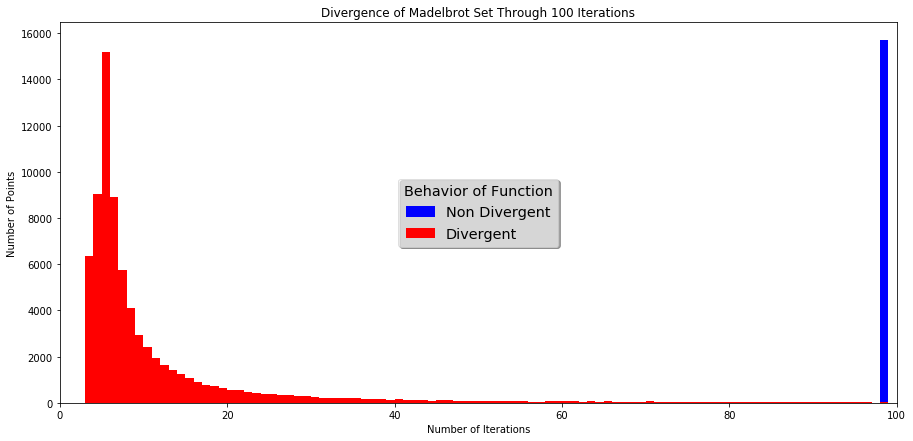

In [3]:
# Set number of iterations (need value to set x limits of plot)
maxIterations = 100
# use function defined above to obtain divergence/ non-divergence counts
counts, working_set, divergent_set = show_mandlebrot_set(maxloops=maxIterations)

# Set plot size
plt.figure(figsize=(15,7))

# Create histogram with red bars indicating number of points that diverged
# and blue bar indicating number of points that didn't diverge after 100 iterations.
bins = np.arange(0, maxIterations, 1) # fixed bin size
plt.hist(working_set, bins, facecolor='B', label = 'Non Divergent');
plt.hist(divergent_set, bins, facecolor='R', label = 'Divergent');


# Customize the histogram
plt.xlabel('Number of Iterations')
plt.ylabel('Number of Points')
plt.title('Divergence of Madelbrot Set Through 100 Iterations')
plt.xlim([0, maxIterations])

# Add legend to histogram
legend = plt.legend(loc='center', shadow=(True), title='Behavior of Function',fontsize='x-large', borderaxespad=3)
plt.setp(legend.get_title(),fontsize='x-large')
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

# Display percentage of non diverging points
totalPnts = 299*301
percent = len(working_set)/totalPnts * 100.0
print('Number of initial points: %17.f' % totalPnts)
print("Number of Point that didn't diverge: ", len(working_set))
print("Percentage of non-diverging points: %7.2f" % percent + "%")

# Check to make sure we are not missing any points
assert( np.abs( (len(working_set) + len(divergent_set)) - 299*301 ) <= 1e-12 )

We see that 15692 points (out of the original 89999) have survived the first 100 iterations without diverging. Approximately 83% of the points diverge very quickly! 

Our primary task to is determine how many points have a limit cycle of $n$ where $n=1,2,3,...,100$. We expect that the sum of the points with limit cycles will be less than roughly 15500. If the sum is greater, than we have made an error in our analysis.

This next function will find points that appear to loop back to a reference value.

In [4]:
def mandalbrotFindNumberOfLimitCycle(nx, ny, xlim, ylim, warmup = 100, maxloops=100, tol = 1e-3):
    """
    This function finds the points in the Mandlebrot set which loops, or returns to the same given value.
    
    Parameters:
        nx:       Number of x divisions
        ny:       Number of y divisions
        xlim:     The x-limits, input as a list [min, max].
        ylim:     The y-limits, input as a list [min, max].
        warmup:   To avoid unpredictability, this number of iterations are performed before the analysis begins
        maxLoops: Number of iterations to analyze
    
    Returns:
        numLoopPoints:  The number of points in the mandlebrot set which loop.
        countPerCycle:  The amount of looping per loop period, from 1 to the maxLoops.
        nonZero:        An array of size nx* ny such that it has 1 if the point
                        apparently loops, and 0 otherwise.
    """
    #Setup Conditions
    x = np.linspace( xlim[0], xlim[1], nx )
    y = np.linspace( ylim[0], ylim[1], ny )
    xx, yy = np.meshgrid( x, y )
    c = xx + yy*1j    
    z = 0.0 + 0.0j
    
    #Warm up the mandlebrot set.
    for i in range(warmup):
        z = z**2 + c
    
    #The new original to compare against.
    z1 = z
    
    #To mark off which points have been identified as cycling.
    nonZero = np.zeros([ny, nx], dtype=np.int16)
    
    #Find the points.
    countPerCycle = []
    for i in range(1, maxloops+1):
        z = z**2 + c
        comparison = np.isclose(z, z1, rtol = tol)
        comparison[nonZero == 1] = 0
        nonZero[comparison>0] = 1
        countPerCycle.append((i, len(np.nonzero(comparison)[0])))
        numLoopPoints = len(np.nonzero(nonZero)[0])
        
    return numLoopPoints, countPerCycle, nonZero

### On What Was Done:
The function above was difficult and time consuming to make, in that the information stated about the Mandelbrot set in the instructions was not clear until very recently. As such, there were numerous technical issues that went into making the function. 

Firstly, it is reasonable to assert that given the nature of the Mandelbrot set as a discrete recurrence relation, values which return to a given value will always cycle back to that value in that given way, rather than, say, returning to that value quickly twice, before taking a long break and then doing that again like what some combinations of sine and cosine waves can do. 

Secondly, the Mandelbrot set has some random elements in the beginning which fade away, hence the necessity of the warmup parameter, which initializes the set and, through the preliminary iterations, removes the random element. The significance of this was in the n=1 stable points. Random noise, introduced to an 'unprimed' Mandelbrot set, disrupts the next value sufficiently enough that the point would not appear as a stable point. 

Another major detail is in the tolerance. Due to the fact that these computations are on a computer, there is floating point imprecision, meaning that it is impossible to demand that the next calculated value returns exactly to its original value. By adjusting the tolerance, it is possible to encompass far too many or insufficiently many points. By looking at the usual magnitudes of the points of the Mandelbrot set (z < 2), we can safely say that demanding 1e-3 precision out of it is fairly reasonable.

### On What We Will Do:
With that function, and previously deduced information, we can gain some statistics about the Mandelbrot set at this particular point. We can calculate how many points there are (given initial conditions), how many points are in the set, how many aren't in the set, how many are periodic, how many are stable, and how many are chaotic points (in the set but do not conform to one of the two previous patterns). From there, we can find the percentage of each relative to another benchmark.

Total Ponts:              89999
Total Mandelbrot Points:  15682
Total Choatic Points:     9943
Total Stable Points:      1999
Total Period Points:      3740

Percent of Mandlebrot Points to Total Points:    17.42464 %
Percent of Chaotic Points to Mandlebrot Points:  63.40390 %
Percent of Stable Points to Mandlebrot Points:   12.74710 %
Percent of Periodic Points to Mandlebrot Points: 23.84900 %
Percent of Periodic Points to Total Points:       4.15560 %


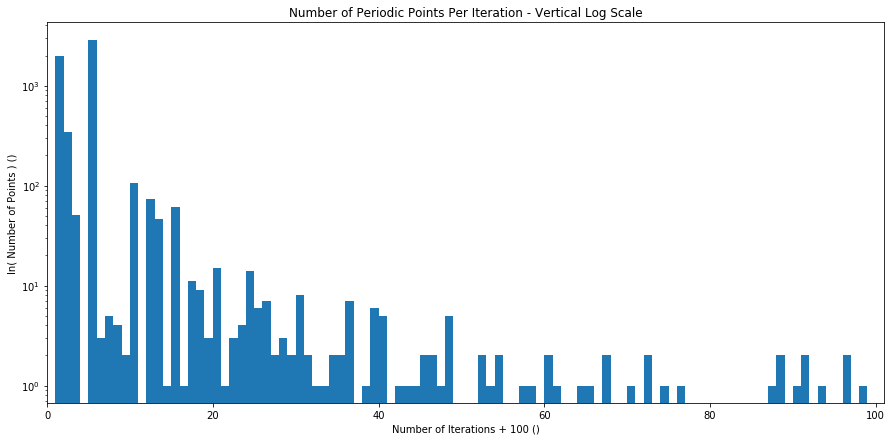

In [5]:
# Hide Error Warning
import warnings
warnings.filterwarnings("ignore")

# Initial Conditions
nx, ny = 299,301
xlim=[-0.75, -0.4] ;  ylim=[0.45, 0.8]

# Find number of points in the grid that are in the Mandlebrot set.
mandlebrotGrid = show_mandlebrot_set(nx, ny, xlim, ylim, 100, allZ=True)
nonZero = np.zeros([ny, nx], dtype=np.int16)
nonZero[mandlebrotGrid == 99] = 1

# Find the number of points in the grid that are part of a limit cycle
totalCycling, countPeriod, array = mandalbrotFindNumberOfLimitCycle(nx, ny, xlim, ylim)

# Compile absolute data.
totalPoints = nx*ny
totalMandlebrotPoints = len(list(np.nonzero(nonZero)[0]))
totalNotInMandlebrot = totalPoints - totalMandlebrotPoints
totalPeriodicStable = totalCycling
totalStable = countPeriod[0][1]
totalPeriodic = totalPeriodicStable - totalStable
totalChaotic = totalMandlebrotPoints - totalPeriodicStable

print('Total Ponts: %18.d' % totalPoints)
print('Total Mandelbrot Points: ', totalMandlebrotPoints)
print('Total Choatic Points: %8.d' % totalChaotic)
print('Total Stable Points: %9.d' % totalStable)
print('Total Period Points: %9.d' % totalPeriodic)
print()

# Compile percentage data
percentMandlebrotTotal = totalMandlebrotPoints/totalPoints * 100
percentPeriodicTotal = totalPeriodic/totalPoints * 100
percentPeriodicMandlebrot = totalPeriodic/totalMandlebrotPoints * 100
percentChaoticMandlebrot = totalChaotic/totalMandlebrotPoints * 100
percentStableMandlebrot = totalStable/totalMandlebrotPoints * 100

print('Percent of Mandlebrot Points to Total Points: %11.5f'  % percentMandlebrotTotal + ' %')
print('Percent of Chaotic Points to Mandlebrot Points: %9.5f'  % percentChaoticMandlebrot + ' %')
print('Percent of Stable Points to Mandlebrot Points: %10.5f'  % percentStableMandlebrot + ' %')
print('Percent of Periodic Points to Mandlebrot Points: %.5f'  % percentPeriodicMandlebrot + ' %')
print('Percent of Periodic Points to Total Points: %13.5f'  % percentPeriodicTotal + ' %')

# Create the Histogram Data
results = []
for entry in countPeriod:
    for numTimes in range(entry[1]):
        results.append(entry[0])
        
# Customize the Histrogram
plt.figure(figsize=(15,7))
plt.yscale('log')
plt.xlabel('Number of Iterations + 100 ()')
plt.ylabel('ln( Number of Points ) ()')
plt.title('Number of Periodic Points Per Iteration - Vertical Log Scale')
plt.xlim([0, 101])

n, bins, patches = plt.hist(results, bins = range(0, 101));

### On The Results:

As we can see from the above results, the majority of the periodic points were clustered around n = 5, with the second most being the stable points at n = 1. This is rather interesting; why it should be that n = 5 is most common is not known. Furthermore, we can see that in this given region, the majority of points are not in the Mandelbrot set; and of those in the Mandelbrot set, the majority of points are chaotic. Only 36% of the points in the Mandelbrot set had a clear pattern, of which periodic points outnumbered stable points 2 to 1. This indicates that most points in the Mandelbrot set are there without having a clear pattern why they are; and further that it's more likely for a given point to take some roundabout path rather than return to its same old value in the next iteration.

## Question 2

To create an interesting image of some fractal iterated function, a bunch of time was spent manipulating the colors, zooming in, and focusing on different regions of the fractal. This was purely an exercise in experimentation. Last assignment we created the resonance plot for a driven harmonic oscillator. Every time we ran the code, a few minutes elapsed before the plot appeared. We had an entirely different experience with this plot, which may seem surprising due to the apparent complexity in the fractal images. Evidently, discarding the values that are known to diverge, coupled with the use of matrix operations, significantly reduces the computation cost. As such, plotting the figure below and exporting it to a jpeg file can be completed in a matter of seconds. 

As mentioned, we created many different images, and settled on a fractal iterated function of the following form.

$$z_{n+1}=z_{n}^{3}+c$$

In order to save the image as a jpeg, the savefig function included in matplotlib was utilized. Unfortunately, the function does not support the jpeg format, and a workaround was necessary. We utilized the PIL (python imaging library) and io packages. The savefig function was used to save the image to a BytesIO object. Then the image was converted and saved as a jpeg. The resultant file appears in the directory that contains this jupyter notebook file.

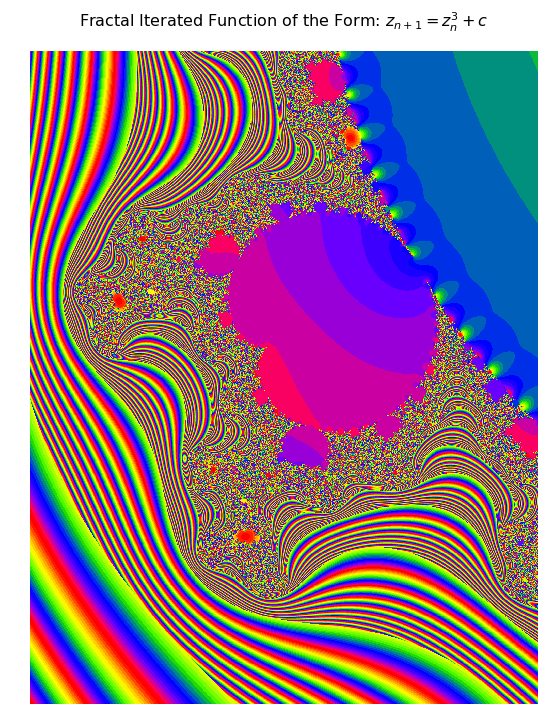

In [6]:
# Import packages necessary to save JPEG
from PIL import Image
from io import BytesIO

# Define initial conditions
x = np.linspace( -0.75, -0.4, 2000 )
y = np.linspace( 0.35, 0.8, 2000 )
xx, yy = np.meshgrid( x, y )
c = xx + yy*1j
z0= 0.0 + 0.0j
z = z0*z0*z0 + c

# Obtain the iterated set
for nloops in range(99):
    working = np.abs(z) < 2.0
    z[working] = z[working]**3 + c[working]
    
# Show Fractal
corners = ( np.min(xx), np.max(xx), np.min(yy), np.max(yy) )
plt.figure( figsize=(12,12) )
title = 'Fractal Iterated Function of the Form: $z_{n+1}=z_{n}^{3}+c$ \n'
plt.title(title, fontsize=16)
plt.imshow( np.abs(z), extent=corners)
plt.set_cmap('prism')
plt.axis('off')

# Instantiate temp object
f = BytesIO()
# Save file to temp object
plt.savefig(f, format = 'png')
# Convert file to jpeg and save in current directory
im = Image.open(f)
rgb_im = im.convert('RGB')
rgb_im.save('Mandelbrot_Plot.jpg')

# Conclusion

An apparent trend in PHYS 381 has been established- introduce a new mathematical concept along with a branch of numerical methods that is appropriate for the problem at hand. This week was no exception. While we have previously seen applications of recursion, the idea of using iterated function to produce a geometric figure (fractal) was brand new material. The formula looks innocent. The image looks ridiculously complicated. 

When performing operations on a large set of data, such as the iterated function set, the use of matrix operations appears to be the logical choice. While the use of loops can accomplish the same calculations, using matrix operations can prove to reduce the computational cost. The concept of using matrix operations seems simple. The execution proved difficult.

The biggest hurdle in this assignment was conceptualizing an algorithm that would determine if a point looped back to its original value, coupled with the requirement that this algorithm must work for all the behaviors exhibited by the points of the Mandelbrot set. Finally, some check of the results would be necessary. No theory was found, for which the results could be compared against. We only knew that the number of periodic points must be less than (or equal) to the number of non-diverging points, as that defined our starting set.

Our results showed that roughly 4% of our initial set resulted in periodic motion (3740 total points). This is certainly less than the 17% remaining after the first 100 iterations, and thus entirely possible. A more thorough check is required to validate this number- perhaps confirming it with an alternative method.

While the task of this assignment has pushed our computational skills, attempting to manipulate the data as we have done, most certainly has minimized its ominous nature. We believe we have made a significant step-forward when it comes to dealing with large sets of data, and problems that are initially daunting.